# Graph Deep Learning on Graph to study Fake News

In [61]:
!pip install dgl

In [62]:
!pip install torch_geometric

^C
Traceback (most recent call last):
  File "/home/crvr/Ulm/M1/.venv/bin/pip", line 8, in <module>
    sys.exit(main())
             ^^^^^^
  File "/home/crvr/Ulm/M1/.venv/lib/python3.12/site-packages/pip/_internal/cli/main.py", line 78, in main
    command = create_command(cmd_name, isolated=("--isolated" in cmd_args))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/crvr/Ulm/M1/.venv/lib/python3.12/site-packages/pip/_internal/commands/__init__.py", line 114, in create_command
    module = importlib.import_module(module_path)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/importlib/__init__.py", line 90, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1387, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1360, in _find_and_load
  File "<frozen importlib._bootstr

In [ ]:
from torch_geometric.datasets import UPFD
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, GCNConv, global_mean_pool
from torch.nn.modules import Linear
from torch_geometric.transforms import ToUndirected
from torch.functional import F
import torch
import argparse
import os.path as osp


The dataset is initialized there. Note that:
- `bert` is the result of a transformer on average tweeets of the author and other info from him/her (as in our article)
- `profile` (user profile info such as number of tweets, followers, and join date)
- `dataset` is either `politifact` or `gossipcop`

Hence this is the same datas as our article except that I struggle to understand their "Network and relations" embedding in our original paper: isn't it already in the edges in a message-passing strategy ?

In [ ]:
from torch_geometric.data import DataLoader
from torch_geometric.datasets import UPFD
import os.path as osp
import torch

_file_ = '..'
file = _file_
dataset = 'gossipcop'  # or 'politifact'
path = osp.join(osp.dirname(osp.realpath(file)), '..', 'data', 'UPFD')

train_dataset_bert = UPFD(path, dataset, 'bert', 'train')
train_dataset_profile = UPFD(path, dataset, 'profile', 'train')
train_dataset_spacy = UPFD(path, dataset, "spacy", 'train')
train_dataset_content = UPFD(path, dataset, "content", "train")

val_dataset_bert = UPFD(path, dataset, 'bert', 'val')
val_dataset_profile = UPFD(path, dataset, 'profile', 'val')
val_dataset_spacy = UPFD(path, dataset, 'spacy', 'val')
val_dataset_content = UPFD(path, dataset, "content", "val")

test_dataset_bert = UPFD(path, dataset, 'bert', 'test')
test_dataset_profile = UPFD(path, dataset, 'profile', 'test')
test_dataset_spacy = UPFD(path, dataset, 'spacy', 'test')
test_dataset_content = UPFD(path, dataset, "content", "test")


def combine_features(*datasets):
    combined_data = []
    for data_list in zip(*datasets):
        combined_data_point = data_list[0].clone() 
        combined_features = torch.cat([data.x for data in data_list], dim=-1)  
        combined_data_point.x = combined_features  
        combined_data.append(combined_data_point)
    return combined_data


def create_dataset_with_profile():
    return train_dataset_profile, val_dataset_profile, test_dataset_profile


def create_dataset_with_profile_and_content():
    train_combined = combine_features(train_dataset_profile, train_dataset_content)
    val_combined = combine_features(val_dataset_profile, val_dataset_content)
    test_combined = combine_features(test_dataset_profile, test_dataset_content)
    return train_combined, val_combined, test_combined


def create_dataset_with_profile_bert_spacy():
    train_combined = combine_features(train_dataset_profile, train_dataset_bert, train_dataset_spacy)
    val_combined = combine_features(val_dataset_profile, val_dataset_bert, val_dataset_spacy)
    test_combined = combine_features(test_dataset_profile, test_dataset_bert, test_dataset_spacy)
    return train_combined, val_combined, test_combined


def create_dataset_with_all_features():
    train_combined = combine_features(train_dataset_profile, train_dataset_bert, train_dataset_spacy, train_dataset_content)
    val_combined = combine_features(val_dataset_profile, val_dataset_bert, val_dataset_spacy, val_dataset_content)
    test_combined = combine_features(test_dataset_profile, test_dataset_bert, test_dataset_spacy, test_dataset_content)
    return train_combined, val_combined, test_combined


train_dataset, val_dataset, test_dataset = create_dataset_with_all_features()

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Debugging: Print the length of features for the first graph
print(f"Number of total samples: {len(train_dataset) + len(val_dataset) + len(test_dataset)}")
print(f"Length for the model: {len(train_dataset[0].x[0])}")


Number of total samples: 5464
Length for the model: 1388


/home/crvr/Ulm/M1/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
print(train_dataset_bert)
print(train_dataset[0].y)
print(train_dataset[0].x)
print(train_dataset[0].edge_index)
#train_dataset[i] représente l'arbre i
#Le champ x représente la valeur des noeud, il est de taille (n, 778).
#Le champ edge index représente les connexion dans l'abre. Il est de taille (2, n - 1). edge_index[0][i] est
#le père de edge_index[1][i]. En pratique, il se trouve que edge_index[1][i] est toujours un linespace, ce qui est possible
#Le champ y représente si c'est un graphe de fake news ou pas

UPFD(1092, name=gossipcop, feature=bert)
tensor([0])
tensor([[-0.0848, -0.2643, -0.2449,  ..., -0.0624,  0.0178,  0.0736],
        [ 0.1415, -0.0493, -0.1443,  ..., -0.0533, -0.0104,  0.0431],
        [-0.0319,  0.0562,  0.4386,  ..., -0.0069, -0.0540,  0.0620],
        ...,
        [ 0.0231,  0.1641,  0.0682,  ..., -0.0418, -0.0145,  0.0705],
        [-0.0714,  0.1860,  0.1526,  ..., -0.0289, -0.0128,  0.0473],
        [ 0.0569,  0.1775,  0.1596,  ..., -0.0256,  0.0195,  0.0659]])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          1, 70, 74],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
     

### Model

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

@torch.no_grad()
def plot_roc_curve(loader, model):
    model.eval()

    all_preds = []
    all_labels = []
    
    for data in loader:
        data = data.to(device)
        logits = model(data.x, data.edge_index, data.batch)
        all_preds.append(logits.cpu())
        all_labels.append(data.y.cpu())
    
    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    one_hot_labels = torch.nn.functional.one_hot(all_labels, num_classes=all_preds.size(1)).float()
    for class_idx in range(all_preds.size(1)):
        if class_idx ==1: break
        fpr, tpr, _ = roc_curve(one_hot_labels[:, class_idx], all_preds[:, class_idx])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {class_idx} (AUC = {roc_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.4)
    plt.show()

In [ ]:
class Net(torch.nn.Module):
    """
    This is the same model as the article. They do not specify the dimensions of hidden channels so this is our choice.
    They do not specify the convolution method,  GCN seems to be the best.
    """
    def __init__(self, in_channels, hidden_channels, out_channels, concat=False):
        super().__init__()
        self.concat = concat
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        #self.conv1 = GATConv(in_channels, hidden_channels)
        #self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.mean_pooling = global_mean_pool
        self.lin1 = Linear(hidden_channels, 2 * hidden_channels)
        self.lin2 = Linear(2*hidden_channels,2)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = torch.nn.functional.selu(x)
        x = self.conv2(x, edge_index)
        x = torch.nn.functional.selu(x)
        x = self.mean_pooling(x, batch)
        x = torch.nn.functional.selu(x)
        x = self.lin1(x)
        x = torch.nn.functional.selu(x)
        x = self.lin2(x)
        return x.softmax(dim=-1)

In [ ]:
loss_fn = torch.nn.HingeEmbeddingLoss() # They specify that they want  the HingeEmbeddingLoss so we used it. 
device = 'cuda'
def train(model):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        y = torch.tensor([[1,0] if e==1 else [0,1] for e in data.y]).to(device)
        loss = loss_fn(out,y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs

    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test(loader, model):
    model.eval()

    total_correct = total_examples = 0
    for data in loader:
        data = data.to(device)
        pred = model(data.x, data.edge_index, data.batch).argmax(dim=-1)
        total_correct += int((pred ==
         data.y).sum())
        total_examples += data.num_graphs

    return total_correct / total_examples

In [ ]:
# Only the user profile
train_dataset,val_dataset,test_dataset = create_dataset_with_profile()
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

inp_len = len(train_dataset[0].x[0])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1 = Net(inp_len, 128,train_dataset_bert.num_classes, concat=True).to(device)
optimizer = torch.optim.Adam(model1.parameters(), lr=5e-4,amsgrad=True)#, weight_decay=0.01) # They precise that they use a 5e-4 AMSGrad. here we add a bit of weight decay to avoid over-fitting.

/home/crvr/Ulm/M1/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
for epoch in range(1, 200):
    loss = train(model1)
    train_acc = test(train_loader, model1)
    val_acc = test(val_loader, model1)
    test_acc = test(test_loader, model1)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, 'f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 01, Loss: 0.7382, Train: 0.5586, Val: 0.5495, Test: 0.5559
Epoch: 02, Loss: 0.7143, Train: 0.5980, Val: 0.6081, Test: 0.5920
Epoch: 03, Loss: 0.6984, Train: 0.6722, Val: 0.6886, Test: 0.6806
Epoch: 04, Loss: 0.6817, Train: 0.6877, Val: 0.6996, Test: 0.6950
Epoch: 05, Loss: 0.6675, Train: 0.7170, Val: 0.7289, Test: 0.7101
Epoch: 06, Loss: 0.6584, Train: 0.7161, Val: 0.7308, Test: 0.7177
Epoch: 07, Loss: 0.6532, Train: 0.7234, Val: 0.7363, Test: 0.7248
Epoch: 08, Loss: 0.6489, Train: 0.7308, Val: 0.7418, Test: 0.7313
Epoch: 09, Loss: 0.6402, Train: 0.7454, Val: 0.7527, Test: 0.7376
Epoch: 10, Loss: 0.6362, Train: 0.7527, Val: 0.7637, Test: 0.7426
Epoch: 11, Loss: 0.6310, Train: 0.7509, Val: 0.7637, Test: 0.7507
Epoch: 12, Loss: 0.6291, Train: 0.7692, Val: 0.7784, Test: 0.7543
Epoch: 13, Loss: 0.6203, Train: 0.7711, Val: 0.7875, Test: 0.7744
Epoch: 14, Loss: 0.6122, Train: 0.7967, Val: 0.8132, Test: 0.7953
Epoch: 15, Loss: 0.6056, Train: 0.8489, Val: 0.8388, Test: 0.8377
Epoch: 16,

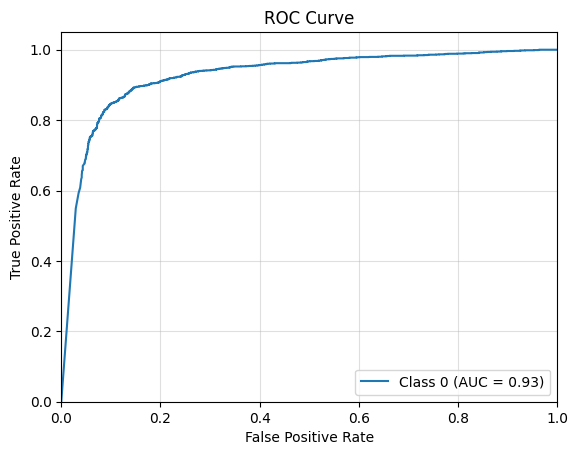

In [ ]:
plot_roc_curve(test_loader,model1)


In [ ]:
# Profile + content
train_dataset,val_dataset,test_dataset = create_dataset_with_profile_and_content()
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

inp_len = len(train_dataset[0].x[0])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2 = Net(inp_len, 128,train_dataset_bert.num_classes, concat=True).to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=5e-4,amsgrad=True)#, weight_decay=0.01) # They precise that they use a 5e-4 AMSGrad. here we add a bit of weight decay to avoid over-fitting.

/home/crvr/Ulm/M1/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
for epoch in range(1, 200):
    loss = train(model2)
    train_acc = test(train_loader, model2)
    val_acc = test(val_loader, model2)
    test_acc = test(test_loader, model2)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, 'f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 01, Loss: 0.7492, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 02, Loss: 0.7449, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 03, Loss: 0.7449, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 04, Loss: 0.7446, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 05, Loss: 0.7378, Train: 0.7711, Val: 0.8022, Test: 0.7765
Epoch: 06, Loss: 0.7167, Train: 0.5833, Val: 0.5769, Test: 0.5815
Epoch: 07, Loss: 0.6795, Train: 0.6749, Val: 0.6923, Test: 0.6827
Epoch: 08, Loss: 0.6365, Train: 0.7170, Val: 0.7326, Test: 0.7198
Epoch: 09, Loss: 0.6153, Train: 0.8782, Val: 0.8993, Test: 0.8745
Epoch: 10, Loss: 0.5955, Train: 0.8095, Val: 0.7930, Test: 0.8129
Epoch: 11, Loss: 0.5865, Train: 0.9029, Val: 0.9286, Test: 0.9038
Epoch: 12, Loss: 0.5672, Train: 0.8755, Val: 0.8755, Test: 0.8704
Epoch: 13, Loss: 0.5626, Train: 0.8068, Val: 0.8114, Test: 0.7980
Epoch: 14, Loss: 0.6054, Train: 0.9203, Val: 0.9304, Test: 0.9239
Epoch: 15, Loss: 0.5674, Train: 0.9231, Val: 0.9322, Test: 0.9266
Epoch: 16,

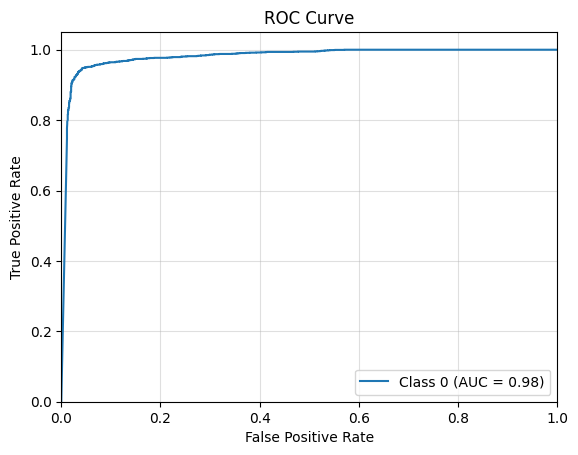

In [ ]:
plot_roc_curve(test_loader,model2)


In [ ]:
# Everything
train_dataset,val_dataset,test_dataset = create_dataset_with_all_features()
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

inp_len = len(train_dataset[0].x[0])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model3 = Net(inp_len, 128,train_dataset_bert.num_classes, concat=True).to(device)
optimizer = torch.optim.Adam(model3.parameters(), lr=5e-4,amsgrad=True)#, weight_decay=0.01) # They precise that they use a 5e-4 AMSGrad. here we add a bit of weight decay to avoid over-fitting.

In [ ]:
for epoch in range(1, 200):
    loss = train(model3)
    train_acc = test(train_loader, model3)
    val_acc = test(val_loader, model3)
    test_acc = test(test_loader, model3)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, 'f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 01, Loss: 0.7469, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 02, Loss: 0.7444, Train: 0.5101, Val: 0.4853, Test: 0.4992
Epoch: 03, Loss: 0.7243, Train: 0.6337, Val: 0.6410, Test: 0.6124
Epoch: 04, Loss: 0.6785, Train: 0.7189, Val: 0.7436, Test: 0.7101
Epoch: 05, Loss: 0.6427, Train: 0.7656, Val: 0.7821, Test: 0.7585
Epoch: 06, Loss: 0.6213, Train: 0.7940, Val: 0.7985, Test: 0.7684
Epoch: 07, Loss: 0.6053, Train: 0.7995, Val: 0.7912, Test: 0.7637
Epoch: 08, Loss: 0.5971, Train: 0.8196, Val: 0.8114, Test: 0.7810
Epoch: 09, Loss: 0.5975, Train: 0.8288, Val: 0.8004, Test: 0.7820
Epoch: 10, Loss: 0.6024, Train: 0.7766, Val: 0.7564, Test: 0.7410
Epoch: 11, Loss: 0.5955, Train: 0.8535, Val: 0.8297, Test: 0.8082
Epoch: 12, Loss: 0.5806, Train: 0.7985, Val: 0.7930, Test: 0.7737
Epoch: 13, Loss: 0.5949, Train: 0.8452, Val: 0.8168, Test: 0.8032
Epoch: 14, Loss: 0.5770, Train: 0.8736, Val: 0.8443, Test: 0.8183
Epoch: 15, Loss: 0.5785, Train: 0.8672, Val: 0.8425, Test: 0.8231
Epoch: 16,

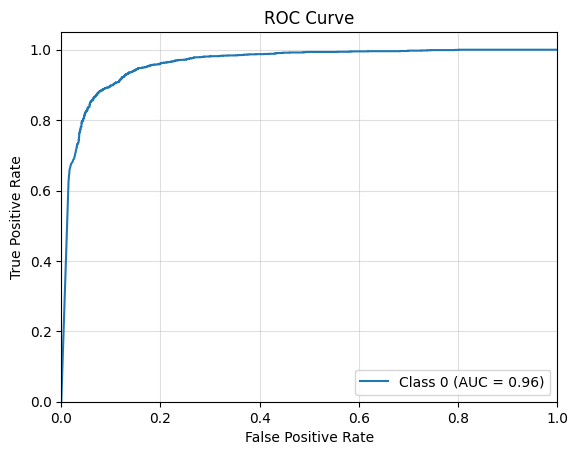

In [ ]:
plot_roc_curve(test_loader,model3)


In [65]:
# Everything
train_dataset,val_dataset,test_dataset = create_dataset_with_profile_bert_spacy()
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

inp_len = len(train_dataset[0].x[0])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model4 = Net(inp_len, 128,train_dataset_bert.num_classes, concat=True).to(device)
optimizer = torch.optim.Adam(model4.parameters(), lr=5e-4,amsgrad=True)#, weight_decay=0.01) # They precise that they use a 5e-4 AMSGrad. here we add a bit of weight decay to avoid over-fitting.

/home/crvr/Ulm/M1/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [66]:
for epoch in range(1, 200):
    loss = train(model4)
    train_acc = test(train_loader, model4)
    val_acc = test(val_loader, model4)
    test_acc = test(test_loader, model4)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, 'f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 01, Loss: 0.7416, Train: 0.5705, Val: 0.5678, Test: 0.5596
Epoch: 02, Loss: 0.7042, Train: 0.7216, Val: 0.7161, Test: 0.7044
Epoch: 03, Loss: 0.6581, Train: 0.7189, Val: 0.6996, Test: 0.6997
Epoch: 04, Loss: 0.6376, Train: 0.7537, Val: 0.7381, Test: 0.7321
Epoch: 05, Loss: 0.6224, Train: 0.7756, Val: 0.7527, Test: 0.7378
Epoch: 06, Loss: 0.6197, Train: 0.7903, Val: 0.7766, Test: 0.7538
Epoch: 07, Loss: 0.6204, Train: 0.7509, Val: 0.7289, Test: 0.7203
Epoch: 08, Loss: 0.6242, Train: 0.7436, Val: 0.7198, Test: 0.7125
Epoch: 09, Loss: 0.6234, Train: 0.7729, Val: 0.7546, Test: 0.7337
Epoch: 10, Loss: 0.6151, Train: 0.8031, Val: 0.7839, Test: 0.7632
Epoch: 11, Loss: 0.6096, Train: 0.7857, Val: 0.7637, Test: 0.7475
Epoch: 12, Loss: 0.6141, Train: 0.7830, Val: 0.7692, Test: 0.7520
Epoch: 13, Loss: 0.6013, Train: 0.7930, Val: 0.7601, Test: 0.7520
Epoch: 14, Loss: 0.5998, Train: 0.8123, Val: 0.7711, Test: 0.7577
Epoch: 15, Loss: 0.5940, Train: 0.8114, Val: 0.7784, Test: 0.7640
Epoch: 16,

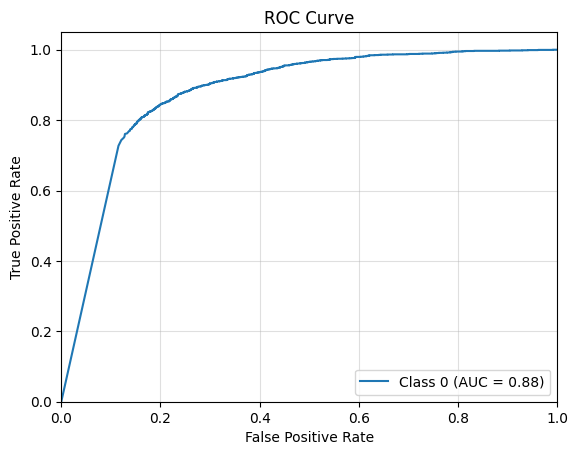

In [67]:
plot_roc_curve(test_loader,model4)


### Weight Decay: todo

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(1078, 256,train_dataset_bert.num_classes, concat=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4,amsgrad=True)
for epoch in range(1, 200):
    loss = train(model)
    train_acc = test(train_loader, model)
    val_acc = test(val_loader, model)
    test_acc = test(test_loader, model)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, 'f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')
plot_roc_curve(test_loader,model)

Epoch: 01, Loss: 0.7405, Train: 0.6364, Val: 0.6465, Test: 0.6362
Epoch: 02, Loss: 0.7072, Train: 0.6383, Val: 0.6392, Test: 0.6404
Epoch: 03, Loss: 0.6789, Train: 0.7363, Val: 0.7473, Test: 0.7376
Epoch: 04, Loss: 0.6416, Train: 0.7473, Val: 0.7546, Test: 0.7308
Epoch: 05, Loss: 0.6328, Train: 0.7701, Val: 0.7692, Test: 0.7467
Epoch: 06, Loss: 0.6243, Train: 0.7784, Val: 0.7729, Test: 0.7475
Epoch: 07, Loss: 0.6165, Train: 0.7949, Val: 0.7857, Test: 0.7561
Epoch: 08, Loss: 0.6121, Train: 0.8004, Val: 0.7839, Test: 0.7561
Epoch: 09, Loss: 0.6018, Train: 0.8086, Val: 0.7857, Test: 0.7619
Epoch: 10, Loss: 0.6013, Train: 0.8187, Val: 0.7821, Test: 0.7708
Epoch: 11, Loss: 0.5988, Train: 0.8168, Val: 0.7784, Test: 0.7679
Epoch: 12, Loss: 0.6063, Train: 0.8278, Val: 0.7839, Test: 0.7726
Epoch: 13, Loss: 0.5938, Train: 0.8416, Val: 0.8004, Test: 0.7739
Epoch: 14, Loss: 0.5853, Train: 0.8324, Val: 0.7857, Test: 0.7703
Epoch: 15, Loss: 0.5864, Train: 0.8599, Val: 0.7949, Test: 0.7768
Epoch: 16,

NameError: name 'plot_roc_curve' is not defined

As in the article: If we do not add weight decay (somehow equivalent to dropout) we overfit on the training but dail to genralize.

## Ablation Study